In [1]:
# Import packages
import os
import re  # regular expressions
import warnings
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em

warnings.simplefilter('ignore')

# Get the MODIS data
et.data.get_data('cold-springs-modis-h4')

# This download is for the fire boundary
et.data.get_data('cold-springs-fire')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))


In [2]:
# Create a path to the pre-fire MODIS h4 data
pre_fire_path = os.path.join("cold-springs-modis-h4",
                             "07_july_2016",
                             "MOD09GA.A2016189.h09v05.006.2016191073856.hdf")


In [3]:
# View dataset metadata
with rio.open(pre_fire_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta


<open DatasetReader name='cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf' mode='r'>


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [4]:
# Print all of the subdatasets in the data
with rio.open(pre_fire_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)


HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:num_observations_1km
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:granule_pnt_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:num_observations_500m
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b01_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b02_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b03_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b04_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09G

In [5]:
# Create empty list to append arrays (of band data)
all_bands = []

# Open the pre-fire HDF4 file
with rio.open(pre_fire_path) as dataset:
    
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has b0 in the name (the bands)
        if re.search("b0.\_1$", name):
            
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                all_bands.append(subdataset.read(1))

# Stack pre-fire reflectance bands
pre_fire_modis = np.stack(all_bands)
pre_fire_modis.shape


(7, 2400, 2400)

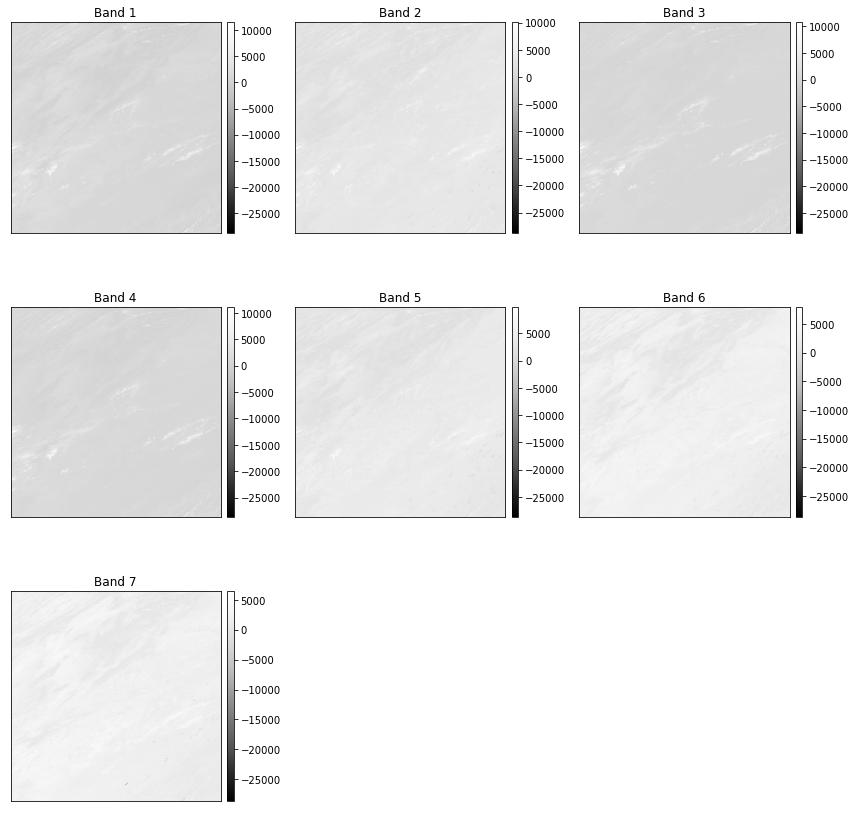

In [6]:
ep.plot_bands(pre_fire_modis,
              scale=False)
plt.show()


In [7]:
# View entire metadata object 
# for the last MODIS band processed in loop
modis_meta


{'driver': 'HDF4Image', 'dtype': 'int16', 'nodata': -28672.0, 'width': 2400, 'height': 2400, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'), 'transform': Affine(463.3127165279165, 0.0, -10007554.677,
       0.0, -463.3127165279167, 4447802.078667), 'tiled': False}

In [8]:
# View just the nodata value
modis_meta["nodata"]


-28672.0

In [9]:
# Mask no data values
pre_fire_modis = ma.masked_where(
    pre_fire_modis == modis_meta["nodata"], pre_fire_modis)


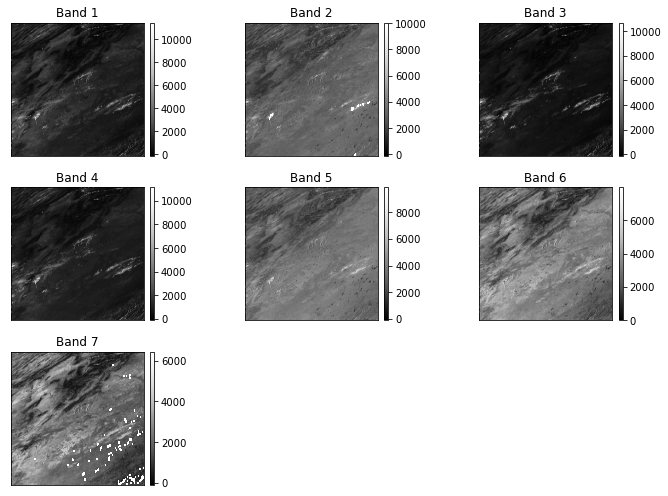

In [10]:
ep.plot_bands(pre_fire_modis,
              scale=False,
              figsize=(10, 7))
plt.show()


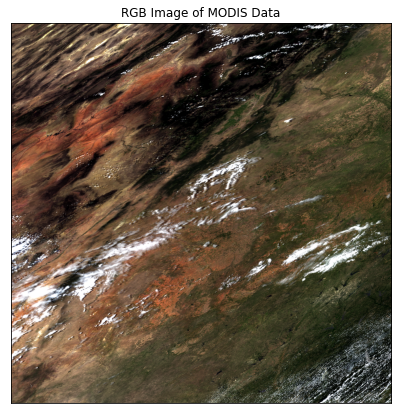

In [11]:
# Plot MODIS RGB
ep.plot_rgb(pre_fire_modis,
            rgb=[0, 3, 2],
            title='RGB Image of MODIS Data',
            stretch=True,
            figsize=(7, 7))

plt.show()


In [13]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

# fire_boundary = gpd.read_file(fire_boundary_path)

# Check the CRS
# fire_boundary.crs
